# Eval runs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import re

pd.set_option('display.max_columns', None)

In [16]:
def process_and_plot(file_path, ylim, front_rr1, full_concat_rr1, with_pos=True):
    # Read the file
    with open(file_path, 'r') as file:
        data = file.readlines()

    results = []

    experiment_pattern = re.compile(r'Perform 1:N Evaluation on (\S+)')
    rr1_pattern = re.compile(r'RR1: ([\d\.]+)')
    concat_rr1_pattern = re.compile(r'Concat-RR1: ([\d\.]+)')

    current_experiment = None

    for line in data:
        exp_match = experiment_pattern.search(line)
        rr1_match = rr1_pattern.search(line)
        concat_rr1_match = concat_rr1_pattern.search(line)
        
        if exp_match:
            current_experiment = exp_match.group(1)
        
        if rr1_match and concat_rr1_match:
            rr1 = float(rr1_match.group(1))
            concat_rr1 = float(concat_rr1_match.group(1))
            results.append((current_experiment[12:], rr1, concat_rr1))

    experiments = [r[0] for r in results]
    rr1_values = [r[1] for r in results]
    concat_rr1_values = [r[2] for r in results]

    if with_pos:
        # Extract x, y coordinates from experiment names
        x_coords = []
        y_coords = []
        for exp in experiments:
            y, x = map(int, exp.split('_'))
            x_coords.append(x)
            y_coords.append(y)

        fig, ax = plt.subplots(figsize=(8, 6))
        sc = ax.scatter(x_coords, y_coords, c=concat_rr1_values, cmap='viridis', edgecolor='black', s=100)
        plt.colorbar(sc, label='Concat-RR1 Accuracy')
        ax.set_xlabel('Azimuth')
        ax.set_ylabel('Altitude')
        ax.set_title('Accuracy Distribution Based on Position')
        for i, txt in enumerate(concat_rr1_values):
            ax.text(x_coords[i], y_coords[i]+1.5, f'{txt:.2f}%', fontsize=8, ha='center', va='center', color='black')
        plt.grid(True)
        plt.show()

    x = np.arange(len(experiments))
    width = 0.4

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x + width/2, concat_rr1_values, width, label='Concat-RR1', color='orange')
    ax.axhline(y=front_rr1, color='blue', linestyle='--', label='FRONT ONLY')
    ax.axhline(y=full_concat_rr1, color='green', linestyle='--', label='CONCAT 25 POSES')
    ax.set_ylabel('Scores')
    ax.set_title('')
    ax.set_xticks(x)
    ax.set_xticklabels(experiments, rotation=90)
    ax.set_ylim(ylim)
    ax.legend()

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = ['blue' if len(exp) > 11 else 'red' for exp in experiments]
    ax.scatter(rr1_values, concat_rr1_values, color=colors, label='RR1')
    ax.axhline(y=front_rr1, color='blue', linestyle='--', label='FRONT ONLY')
    ax.axhline(y=full_concat_rr1, color='green', linestyle='--', label='CONCAT 25 POSES')

    for i, txt in enumerate(experiments):
        ax.annotate(txt, (rr1_values[i], concat_rr1_values[i]), fontsize=8, ha='right')

    ax.set_xlabel('RR1')
    ax.set_ylabel('Concat-RR1')
    ax.set_title('')
    ax.legend()

    plt.grid(True)
    plt.show()

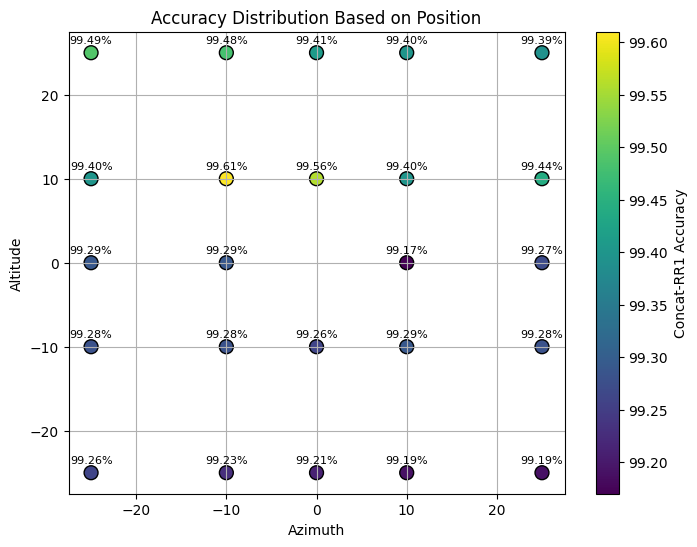

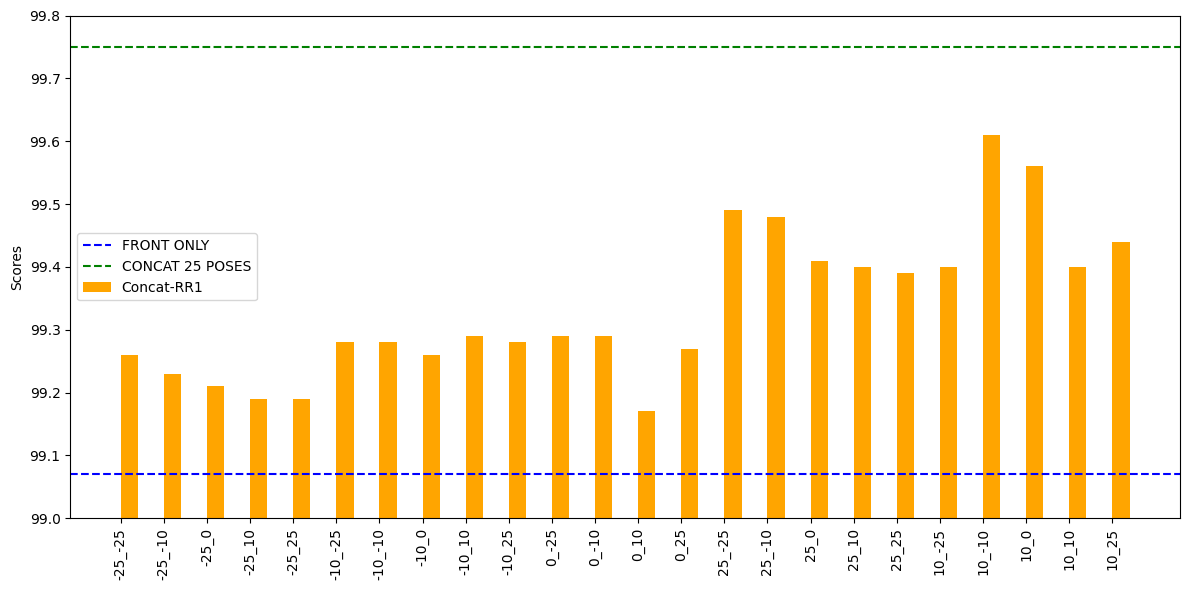

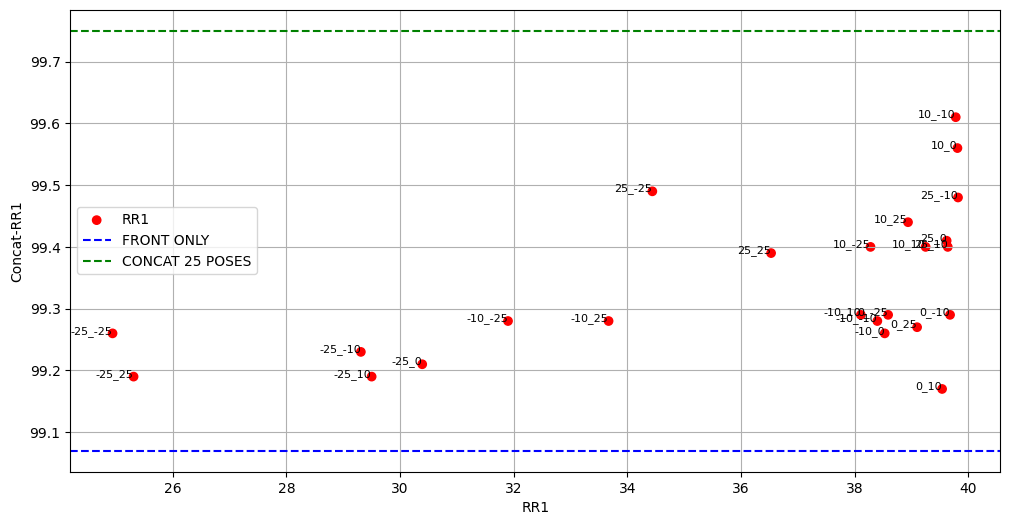

In [17]:
process_and_plot('F:\\Face\\HM_IDENT_3DFR\\src\\notebooks\\perspectives_ms1m.txt', ylim=(99, 99.8), front_rr1=99.07, full_concat_rr1=99.75)

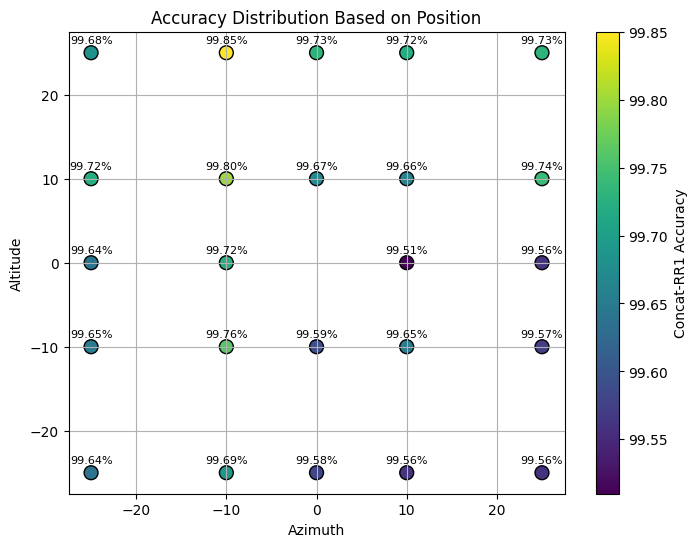

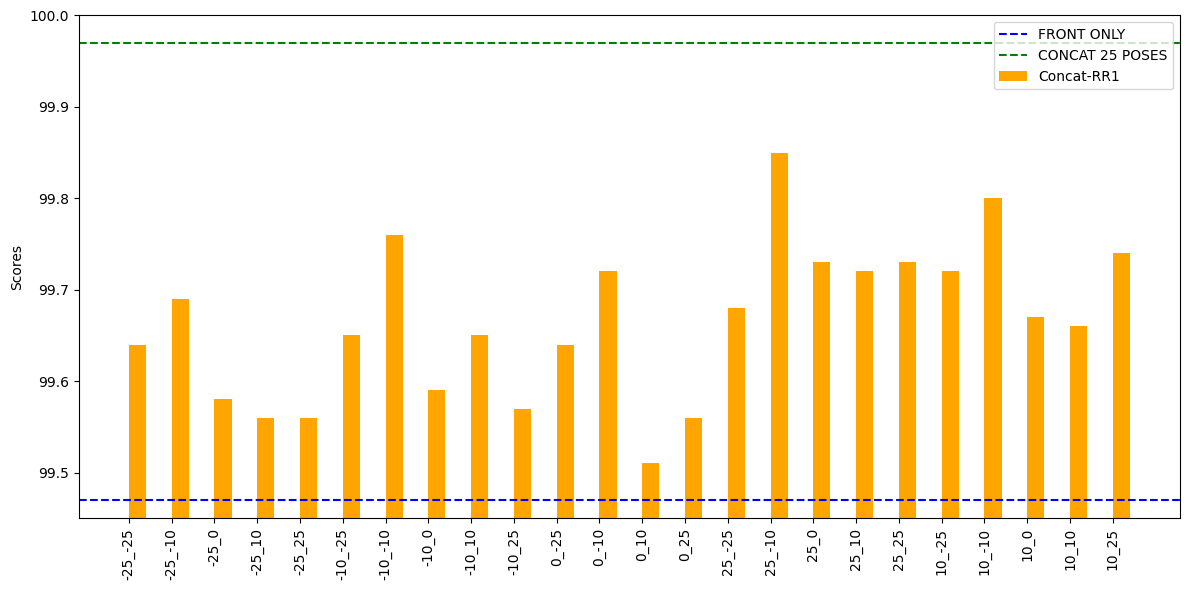

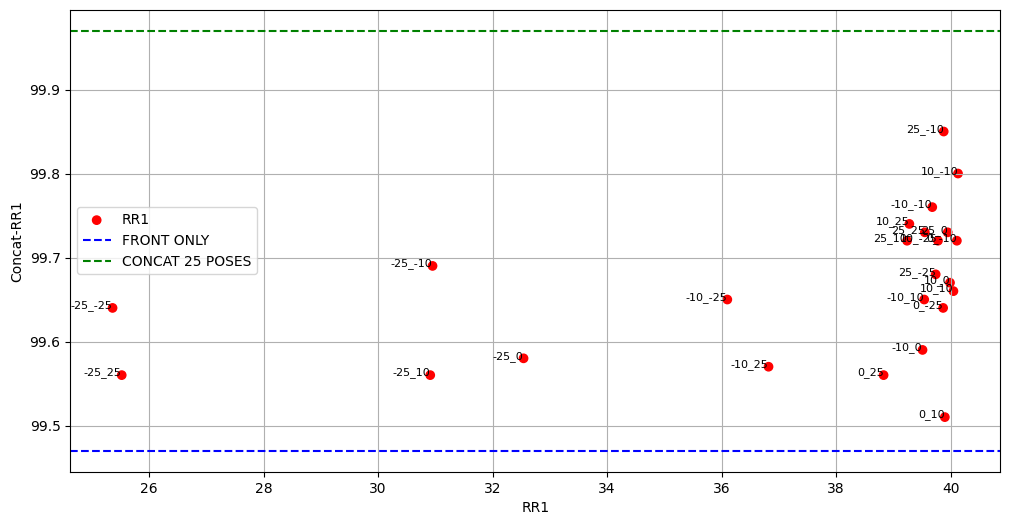

In [18]:
process_and_plot('F:\\Face\\HM_IDENT_3DFR\\src\\notebooks\\perspectives_asia.txt', ylim=(99.45, 100), front_rr1=99.47, full_concat_rr1=99.97)

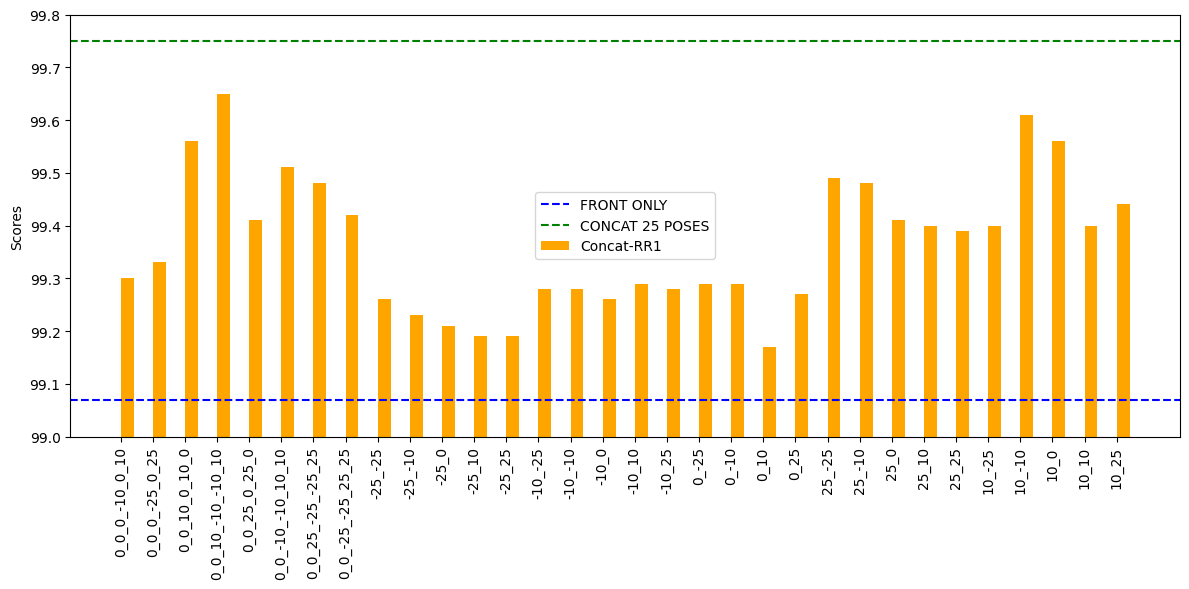

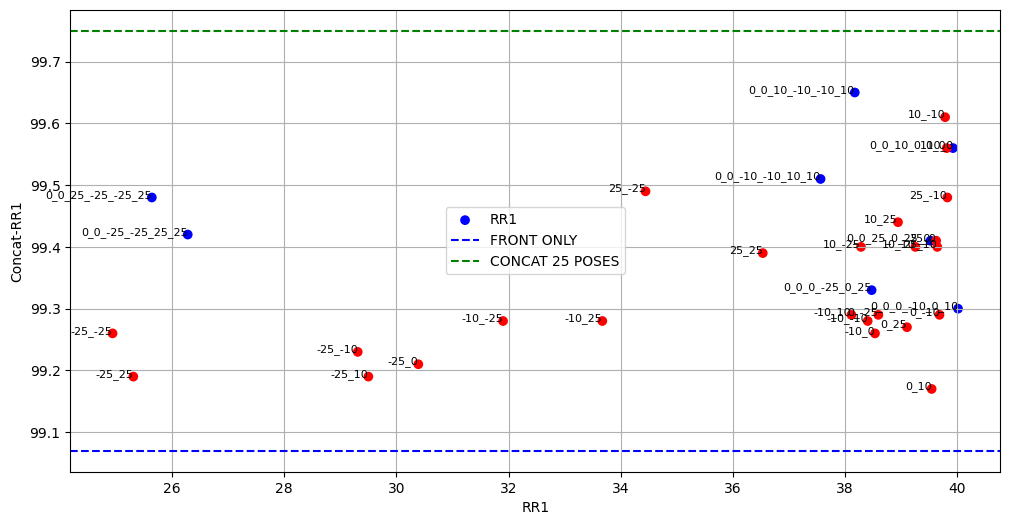

In [19]:
process_and_plot('F:\\Face\\HM_IDENT_3DFR\\src\\notebooks\\perspectives_ms1m_3.txt', ylim=(99, 99.8), front_rr1=99.07, full_concat_rr1=99.75, with_pos=False)

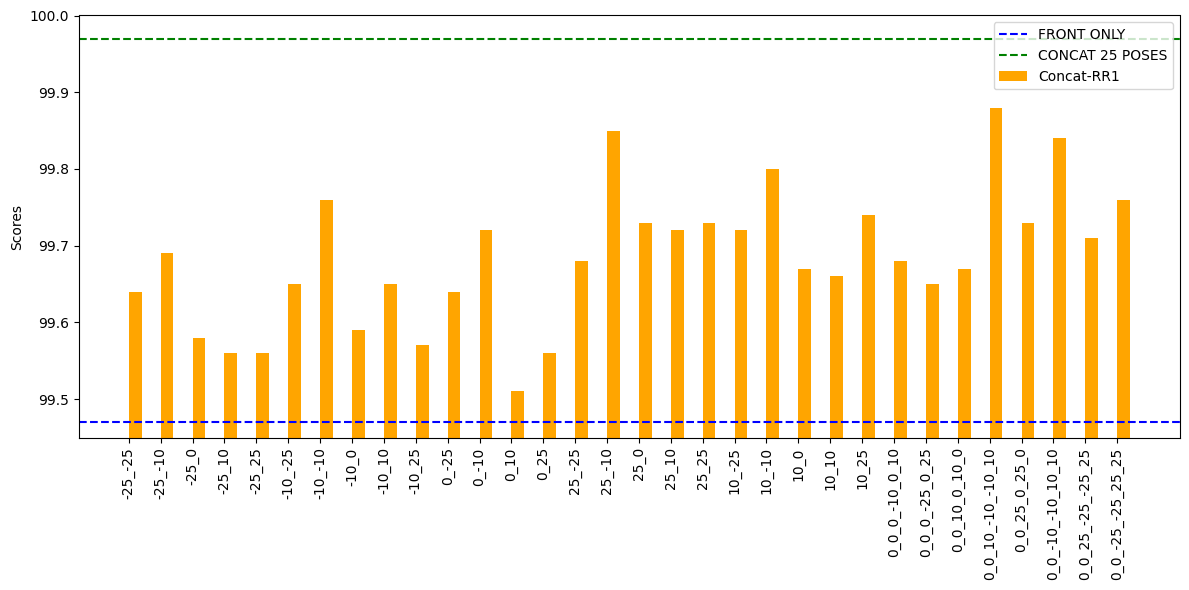

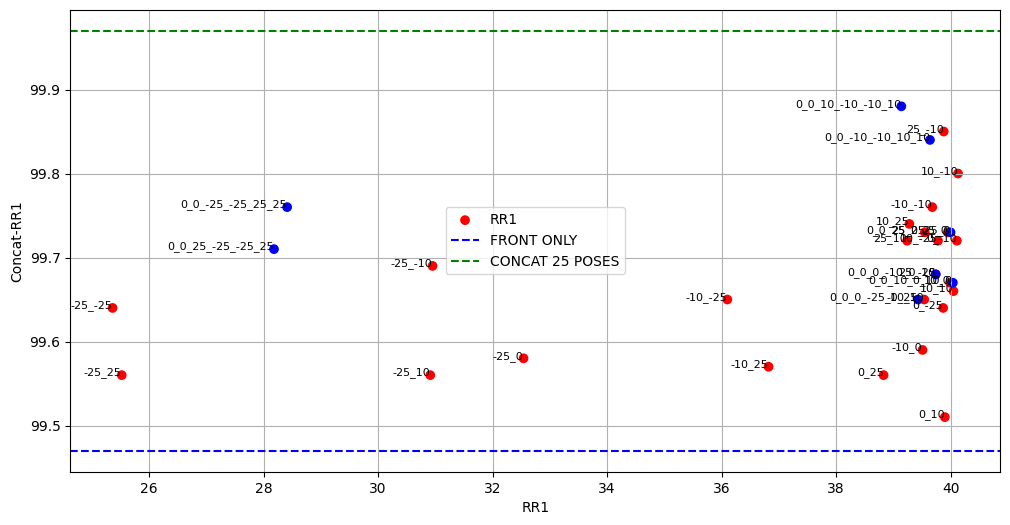

In [20]:
process_and_plot('F:\\Face\\HM_IDENT_3DFR\\src\\notebooks\\perspectives_asia_3.txt', ylim=(99.45, 100), front_rr1=99.47, full_concat_rr1=99.97, with_pos=False)

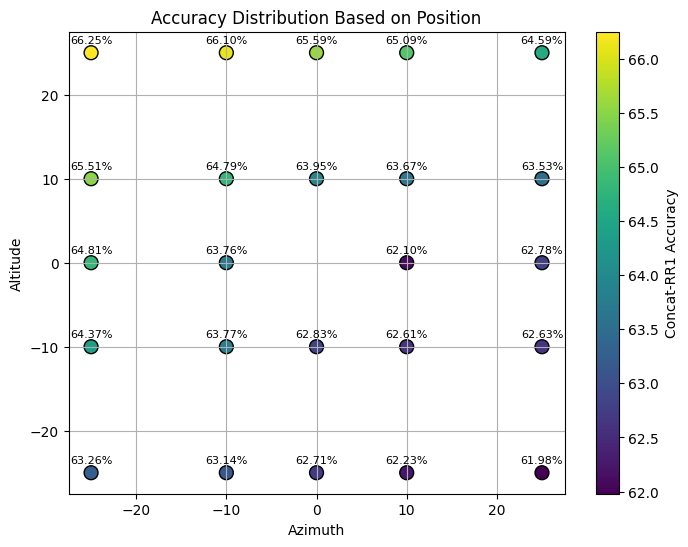

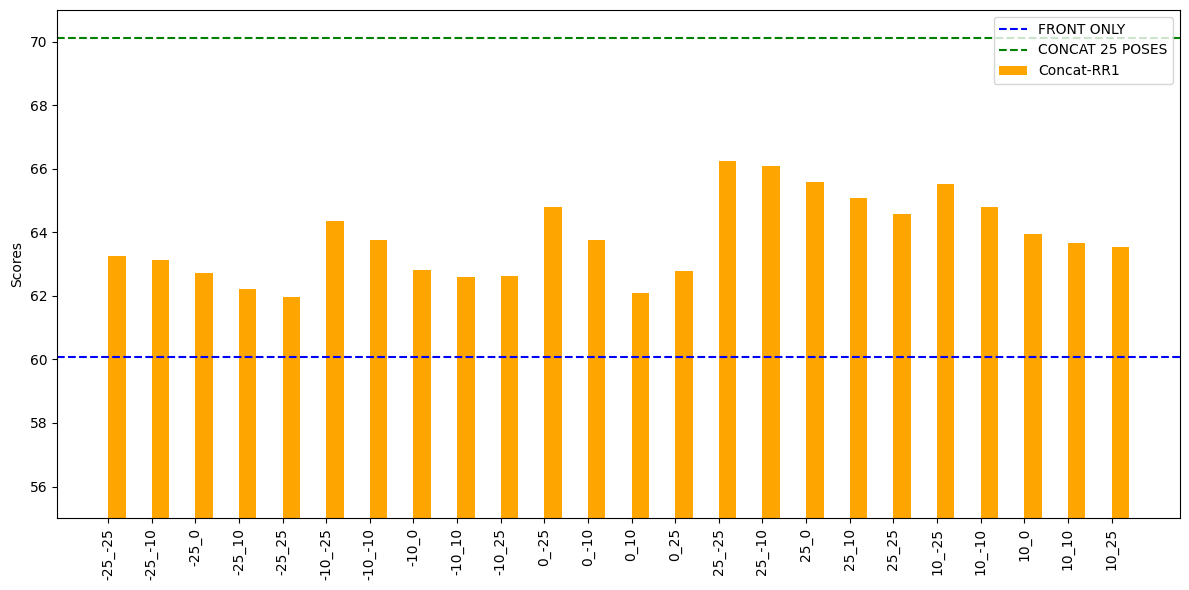

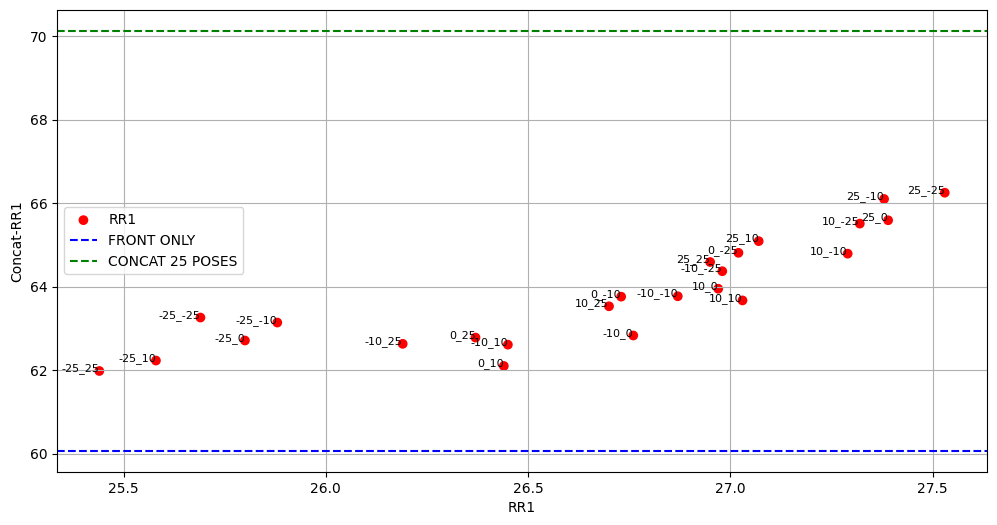

In [26]:
process_and_plot('F:\\Face\\HM_IDENT_3DFR\\src\\notebooks\\perspectives_ms1m_vox2train.txt', ylim=(55, 71), front_rr1=60.07, full_concat_rr1=70.13)

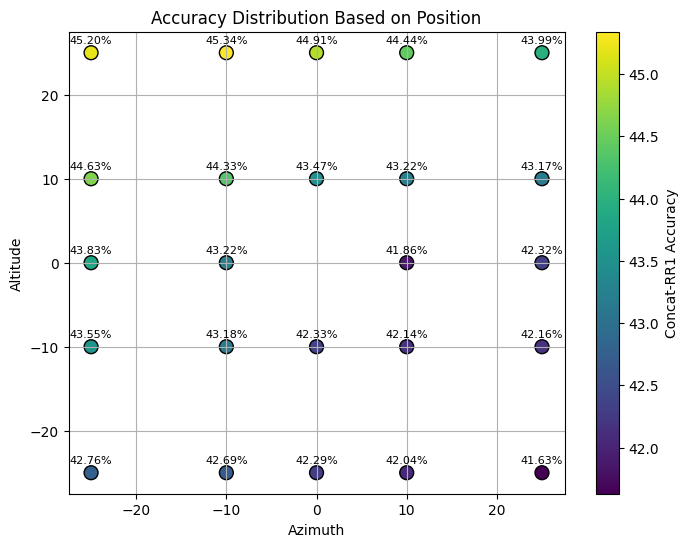

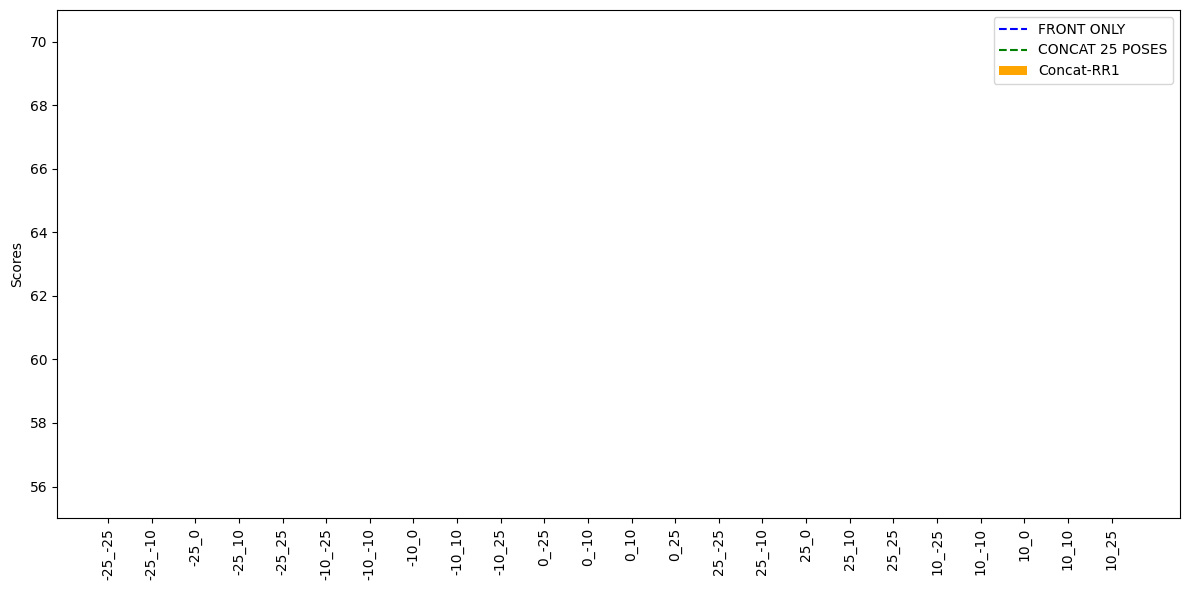

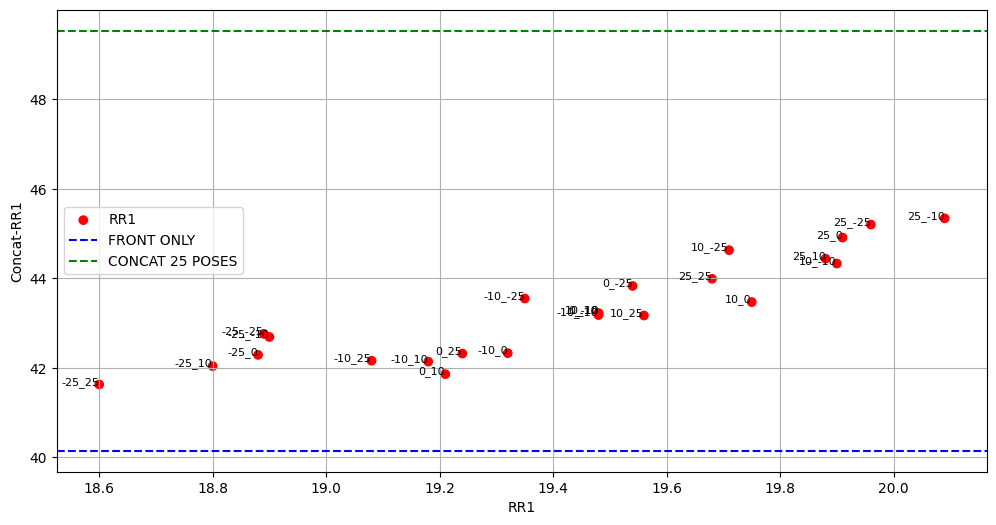

In [27]:
process_and_plot('F:\\Face\\HM_IDENT_3DFR\\src\\notebooks\\perspectives_asia_vox2train.txt', ylim=(55, 71), front_rr1=40.15, full_concat_rr1=49.53)

Dataset len: 553


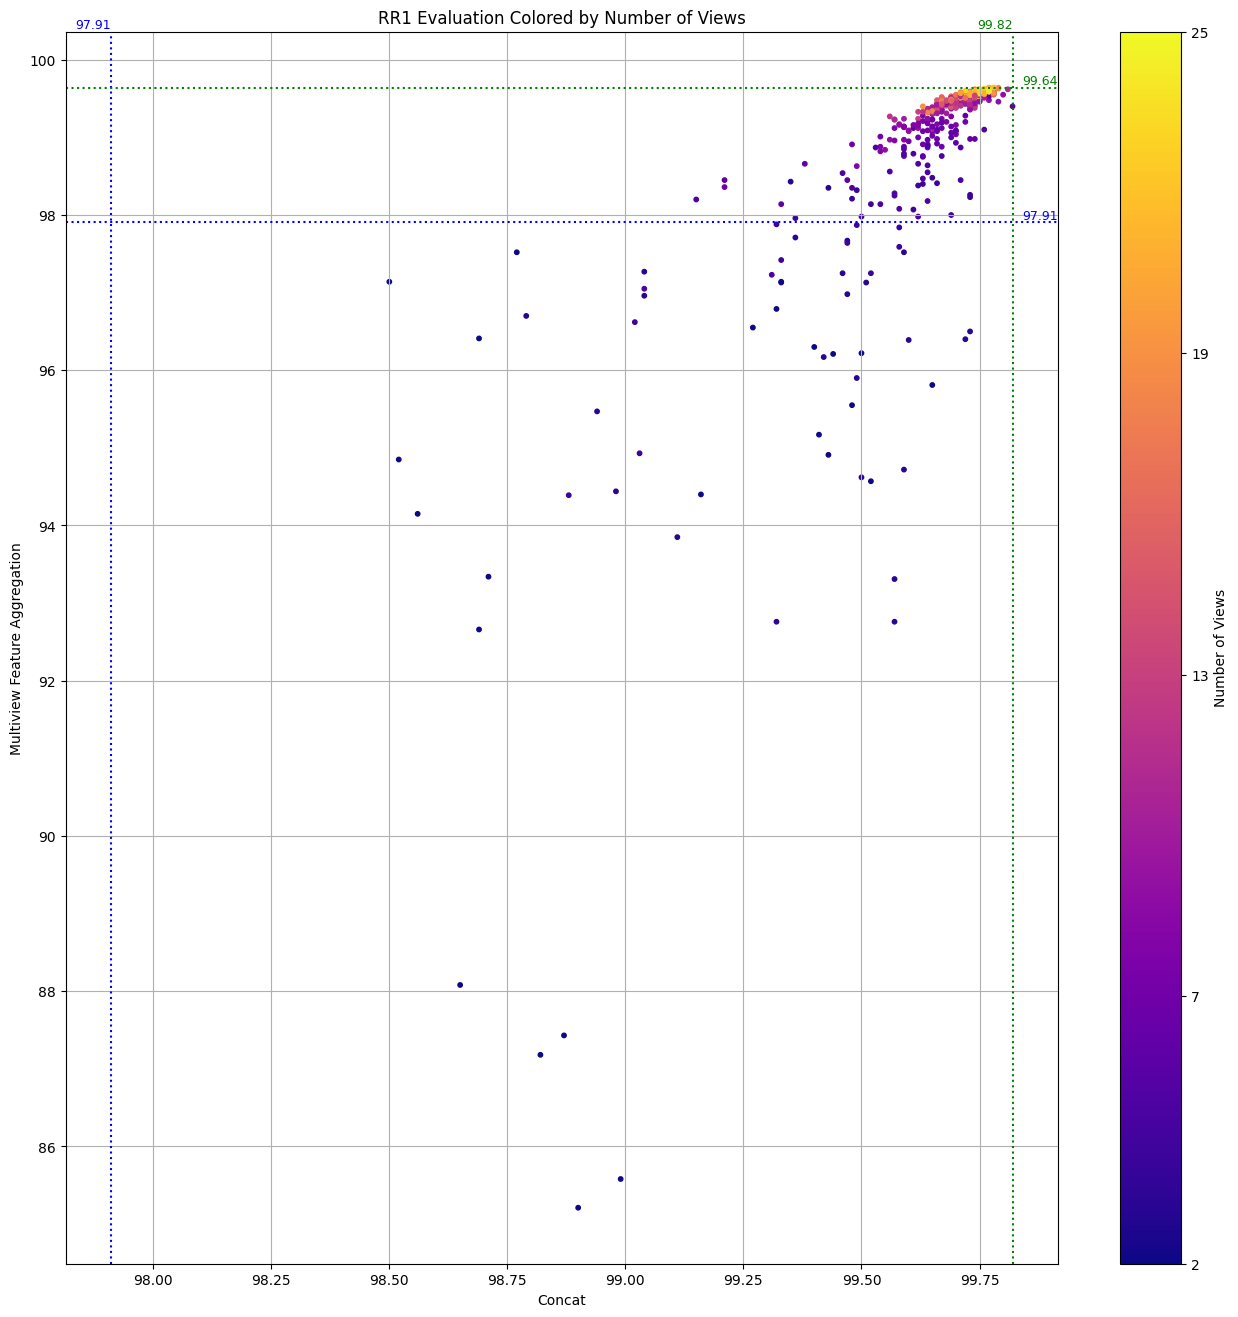

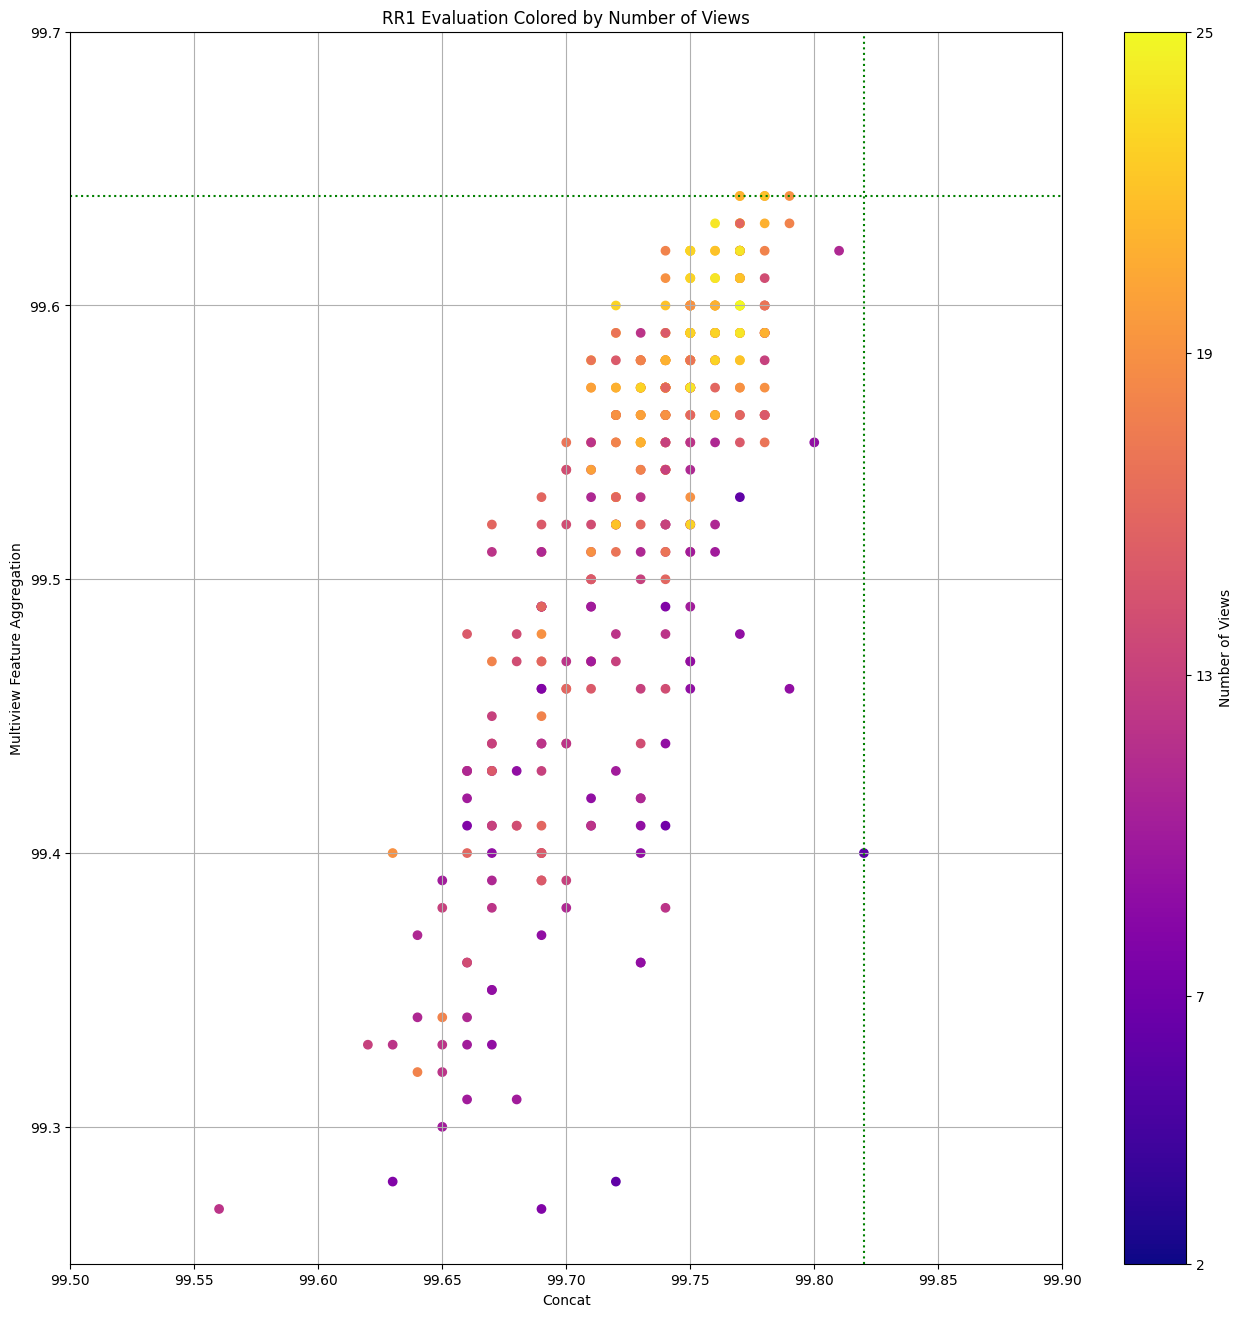

13 24
16 24
9 24
14 24
18 24
3 24
6 24
12 24
15 24
21 24
2 24
5 24
10 24
22 24
24 24
19 24
17 24
20 24
7 24
4 24
8 24
11 24
23 24
25 1


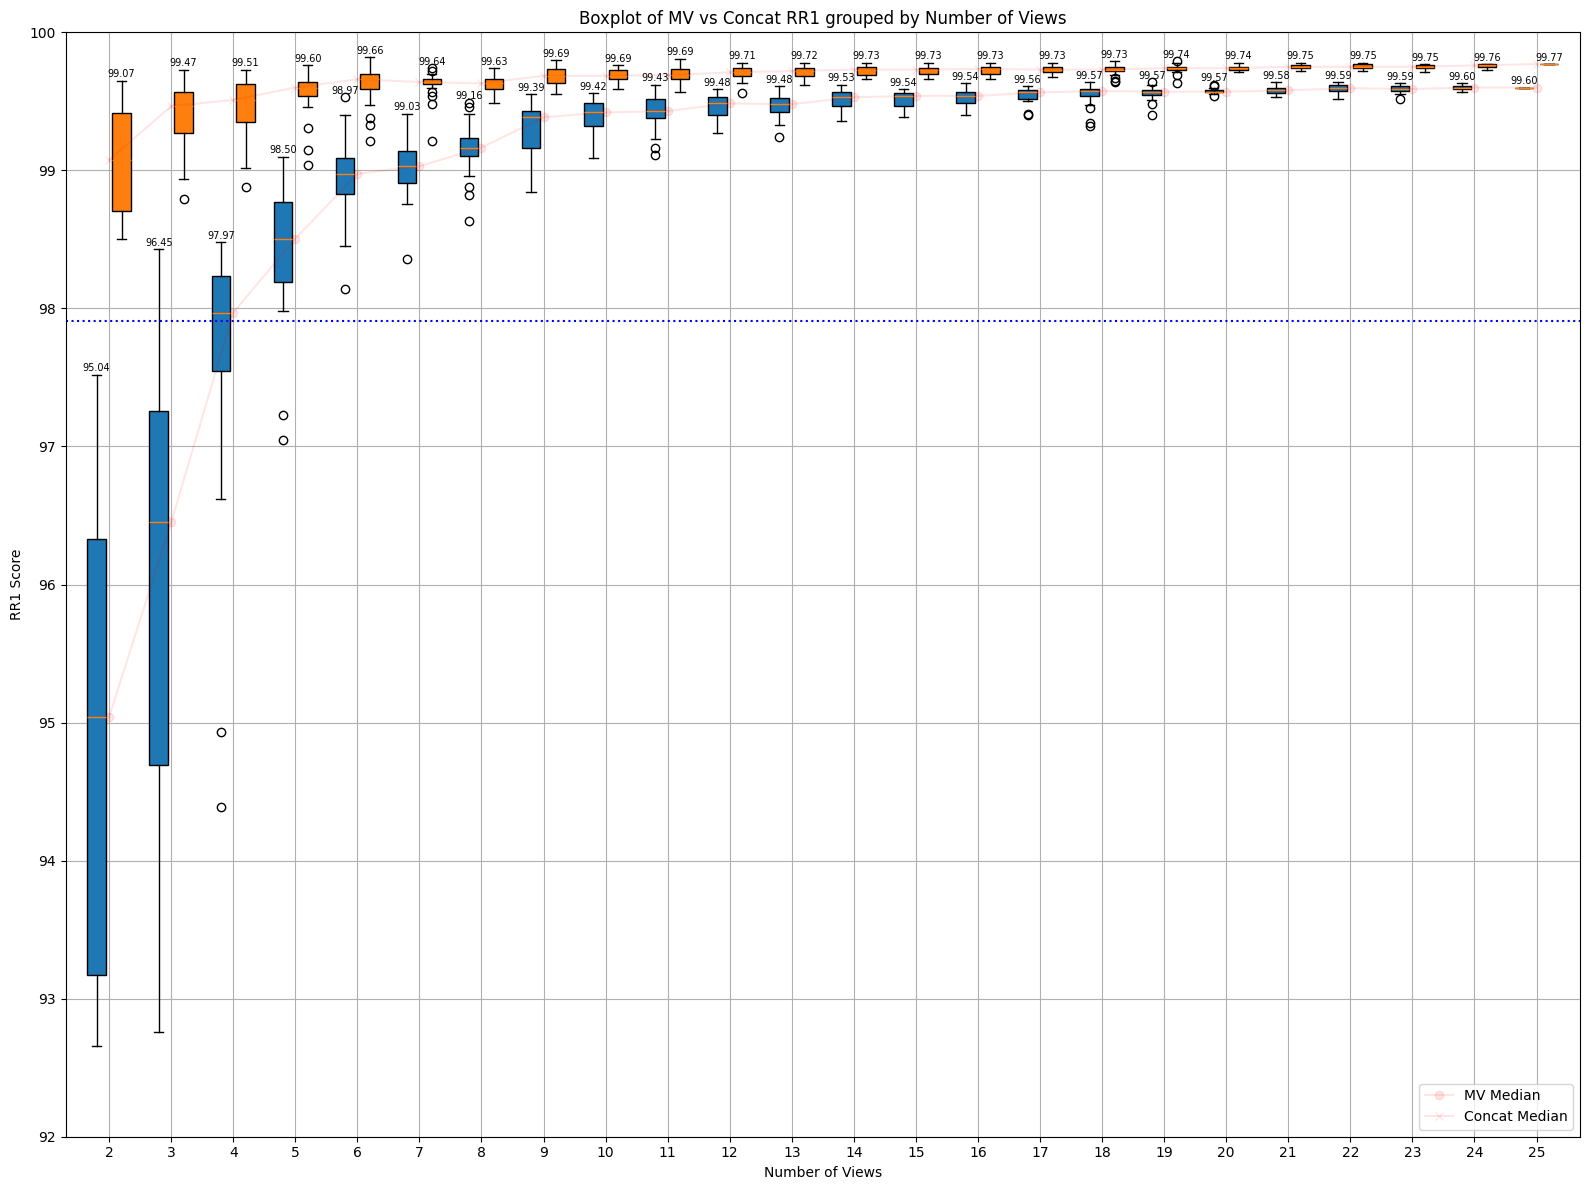

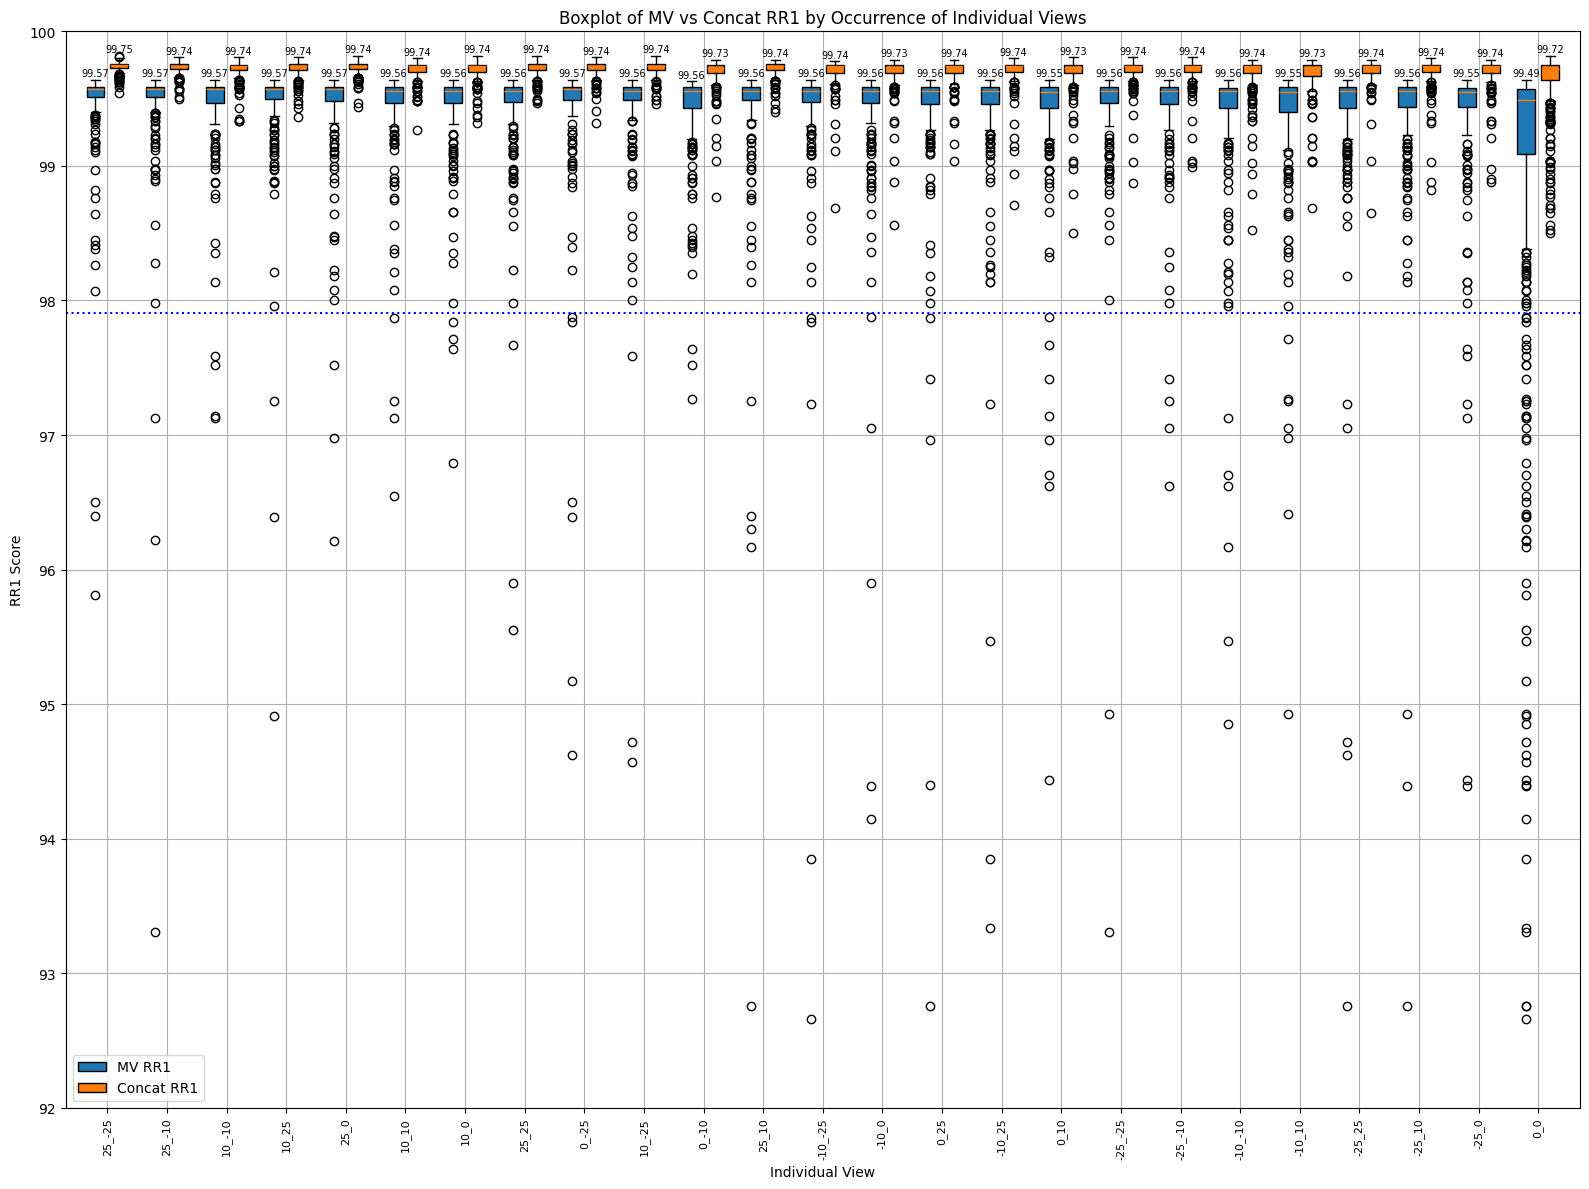

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
from collections import defaultdict

def process_and_plot2(file_path, xlim, ylim):

    with open(file_path, 'r') as file:
        data = file.readlines()

    results = []
    for line in data:
        if "bff_crop_ 0_0 : C1033 E1033 Q18734 ; Evaluation:" in line:
            continue
        if "Evaluation: Front-RR1:" in line:
            line = line.strip()
            dataset_part, eval_part = line.split(";")

            # Parse crop coordinates
            dataset_name, *coords_strs = dataset_part.split(":")[0].strip().split()

            parts = eval_part.split()
            front_rr1 = float(parts[2])
            concat_rr1 = float(parts[6])
            mv_rr1 = float(parts[10])

            results.append((coords_strs , front_rr1, concat_rr1, mv_rr1))

    print(f"Dataset len:", len(results))
    #for i in results:
        #print(i)

    coords_strs = [r[0] for r in results]
    front_rr1_values = [r[1] for r in results]
    concat_rr1_values = [r[2] for r in results]
    mv_rr1_values = [r[3] for r in results]



    # ----------------Scatter ---------------
    lengths = [len(c) for c in coords_strs]
    min_len, max_len = min(lengths), max(lengths)
    norm = mcolors.Normalize(vmin=min_len, vmax=max_len)
    cmap = cm.plasma

    fig, ax = plt.subplots(figsize=(16, 16))
    scatter = ax.scatter(concat_rr1_values, mv_rr1_values, c=lengths, cmap=cmap, norm=norm, s=10)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Number of Views')
    tick_values = np.linspace(min_len, max_len, num=5, dtype=int)
    cbar.set_ticks(tick_values)
    cbar.set_ticklabels([str(v) for v in tick_values])
    #for i, txt in enumerate(coords_strs):
    #    ax.annotate(len(txt), (concat_rr1_values[i]+1.0, mv_rr1_values[i]-0.005), fontsize=8, ha='right')
    ax.set_xlabel('Concat')
    val1 = front_rr1_values[0]
    val2 = max(concat_rr1_values)
    val3 = max(mv_rr1_values)
    ax.axvline(val1, color='b', ls=':')
    ax.axhline(val1, color='b', ls=':')
    ax.text(val1, ax.get_ylim()[1], f'{val1:.2f}', color='b', va='bottom', ha='right', fontsize=9)
    ax.text(ax.get_xlim()[1], val1, f'{val1:.2f}', color='b', va='bottom', ha='right', fontsize=9)
    ax.axvline(val2, color='g', ls=':')
    ax.axhline(val3, color='g', ls=':')
    ax.text(val2, ax.get_ylim()[1], f'{val2:.2f}', color='g', va='bottom', ha='right', fontsize=9)
    ax.text(ax.get_xlim()[1], val3, f'{val3:.2f}', color='g', va='bottom', ha='right', fontsize=9)
    ax.set_ylabel('Multiview Feature Aggregation')
    ax.set_title('RR1 Evaluation Colored by Number of Views')
    plt.grid(True)
    plt.show()

    # ------------- Zoomed in scatter ------------------
    lengths = [len(c) for c in coords_strs]
    min_len, max_len = min(lengths), max(lengths)
    norm = mcolors.Normalize(vmin=min_len, vmax=max_len)
    cmap = cm.plasma

    fig, ax = plt.subplots(figsize=(16, 16))
    scatter = ax.scatter(concat_rr1_values, mv_rr1_values, c=lengths, cmap=cmap, norm=norm)
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Number of Views')
    tick_values = np.linspace(min_len, max_len, num=5, dtype=int)
    cbar.set_ticks(tick_values)
    cbar.set_ticklabels([str(v) for v in tick_values])
    #for i, txt in enumerate(coords_strs):
    #    ax.annotate(len(txt), (concat_rr1_values[i]+1.0, mv_rr1_values[i]-0.005), fontsize=8, ha='right')
    ax.axvline(val2, color='g', ls=':')
    ax.axhline(val3, color='g', ls=':')
    ax.set_xlabel('Concat')
    ax.set_ylabel('Multiview Feature Aggregation')
    ax.set_title('RR1 Evaluation Colored by Number of Views')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    plt.grid(True)
    plt.show()


    # --- Group values by number of views ---
    mv_grouped = defaultdict(list)
    concat_grouped = defaultdict(list)
    for coords, mv_val, concat_val in zip(coords_strs, mv_rr1_values, concat_rr1_values):
        view_count = len(coords)
        mv_grouped[view_count].append(mv_val)
        concat_grouped[view_count].append(concat_val)

    for k,v in concat_grouped.items():
        print(k, len(v))

    lengths_sorted = sorted(set(mv_grouped.keys()).union(concat_grouped.keys()))
    mv_data = [mv_grouped[l] for l in lengths_sorted]
    concat_data = [concat_grouped[l] for l in lengths_sorted]
    mins_mv = [np.min(mv_grouped[l]) for l in lengths_sorted]
    meds_mv = [np.median(mv_grouped[l]) for l in lengths_sorted]
    maxs_mv = [np.max(mv_grouped[l]) for l in lengths_sorted]
    mins_concat = [np.min(concat_grouped[l]) for l in lengths_sorted]
    meds_concat = [np.median(concat_grouped[l]) for l in lengths_sorted]
    maxs_concat = [np.max(concat_grouped[l]) for l in lengths_sorted]
    x_vals = np.arange(1, len(lengths_sorted) + 1)
    positions_mv = x_vals - 0.2
    positions_concat = x_vals + 0.2

    fig, ax = plt.subplots(figsize=(16, 12))

    bp_mv = ax.boxplot(mv_data, positions=positions_mv, widths=0.3, patch_artist=True)
    bp_concat = ax.boxplot(concat_data, positions=positions_concat, widths=0.3, patch_artist=True)

    for patch in bp_mv['boxes']:
        patch.set_facecolor('#1f77b4')  # blue
    for patch in bp_concat['boxes']:
        patch.set_facecolor('#ff7f0e')  # orange

    for i in range(len(lengths_sorted)):
        ax.text(positions_mv[i], maxs_mv[i] + 0.01, f'{meds_mv[i]:.2f}', ha='center', va='bottom', fontsize=7, color='black')
        ax.text(positions_concat[i], maxs_concat[i] + 0.01, f'{meds_concat[i]:.2f}', ha='center', va='bottom', fontsize=7, color='black')

    ax.axhline(val1, color='b', linestyle=':')

    #ax.plot(x_vals, mins_mv, label='MV Min', color='blue', linestyle='--', marker='o', alpha=0.1)
    ax.plot(x_vals, meds_mv, label='MV Median', color='red', linestyle='-', marker='o', alpha=0.1)
    #ax.plot(x_vals, maxs_mv, label='MV Max', color='green', linestyle='--', marker='o', alpha=0.1)
    #ax.plot(x_vals, mins_concat, label='Concat Min', color='blue', linestyle='--', marker='x', alpha=0.1)
    ax.plot(x_vals, meds_concat, label='Concat Median', color='red', linestyle='-', marker='x', alpha=0.1)
    #ax.plot(x_vals, maxs_concat, label='Concat Max', color='green', linestyle='--', marker='x', alpha=0.1)

    ax.set_ylim(max(92, np.min(mv_rr1_values)), 100)
    ax.set_xticks(x_vals)
    ax.set_xticklabels(lengths_sorted)
    ax.set_xlabel('Number of Views')
    ax.set_ylabel('RR1 Score')
    ax.set_title('Boxplot of MV vs Concat RR1 grouped by Number of Views')
    ax.grid(True)
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()




    # Box Plot Views
    mv_bucket = defaultdict(list)
    concat_bucket = defaultdict(list)

    for coords, mv_val, concat_val in zip(coords_strs, mv_rr1_values, concat_rr1_values):
        for coord in coords:
            mv_bucket[coord].append(mv_val)
            concat_bucket[coord].append(concat_val)

    sorted_coords = sorted(mv_bucket.keys(), key=lambda k: np.mean(mv_bucket[k]), reverse=True)

    mv_data = [mv_bucket[coord] for coord in sorted_coords]
    concat_data = [concat_bucket[coord] for coord in sorted_coords]

    fig, ax = plt.subplots(figsize=(max(16, len(sorted_coords) * 0.6), 12))

    positions_mv = np.arange(1, len(sorted_coords) + 1) - 0.2
    positions_concat = np.arange(1, len(sorted_coords) + 1) + 0.2

    bp_mv = ax.boxplot(mv_data, positions=positions_mv, patch_artist=True, widths=0.3)
    bp_concat = ax.boxplot(concat_data, positions=positions_concat, patch_artist=True, widths=0.3)

    for patch in bp_mv['boxes']:
        patch.set_facecolor('#1f77b4')  # Blue
    for patch in bp_concat['boxes']:
        patch.set_facecolor('#ff7f0e')  # Orange

    for i, (mv_vals, concat_vals) in enumerate(zip(mv_data, concat_data)):
        ax.text(positions_mv[i], np.max(mv_vals) + 0.01, f'{np.median(mv_vals):.2f}', 
                ha='center', va='bottom', fontsize=7, color='black')
        ax.text(positions_concat[i], np.max(concat_vals) + 0.01, f'{np.median(concat_vals):.2f}', 
                ha='center', va='bottom', fontsize=7, color='black')
        
    ax.axhline(val1, color='b', linestyle=':')

    ax.set_ylim(max(92, np.min(mv_rr1_values)), 100)
    ax.set_xticks(np.arange(1, len(sorted_coords) + 1))
    ax.set_xticklabels(sorted_coords, rotation=90, fontsize=8)
    ax.set_xlabel('Individual View')
    ax.set_ylabel('RR1 Score')
    ax.set_title('Boxplot of MV vs Concat RR1 by Occurrence of Individual Views')
    ax.legend([bp_mv["boxes"][0], bp_concat["boxes"][0]], ['MV RR1', 'Concat RR1'], loc='lower left')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


process_and_plot2('perspectives_ms1m_bff.txt', xlim=(99.5, 99.9), ylim=(99.25, 99.7))

Dataset len: 202


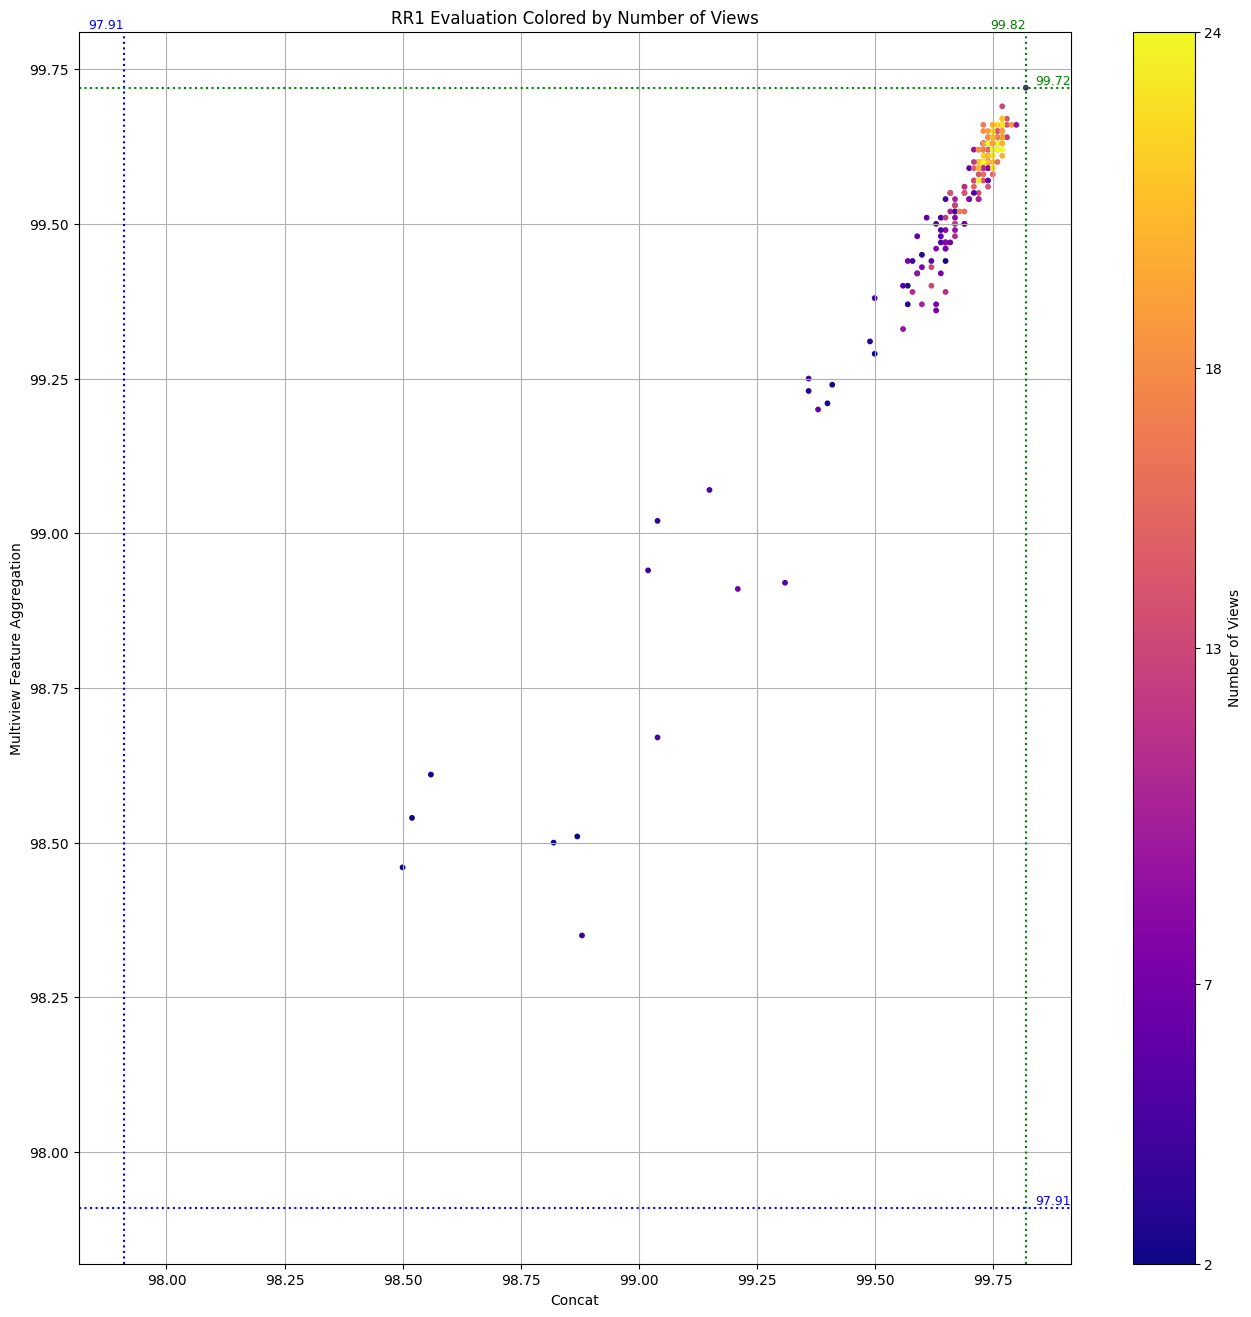

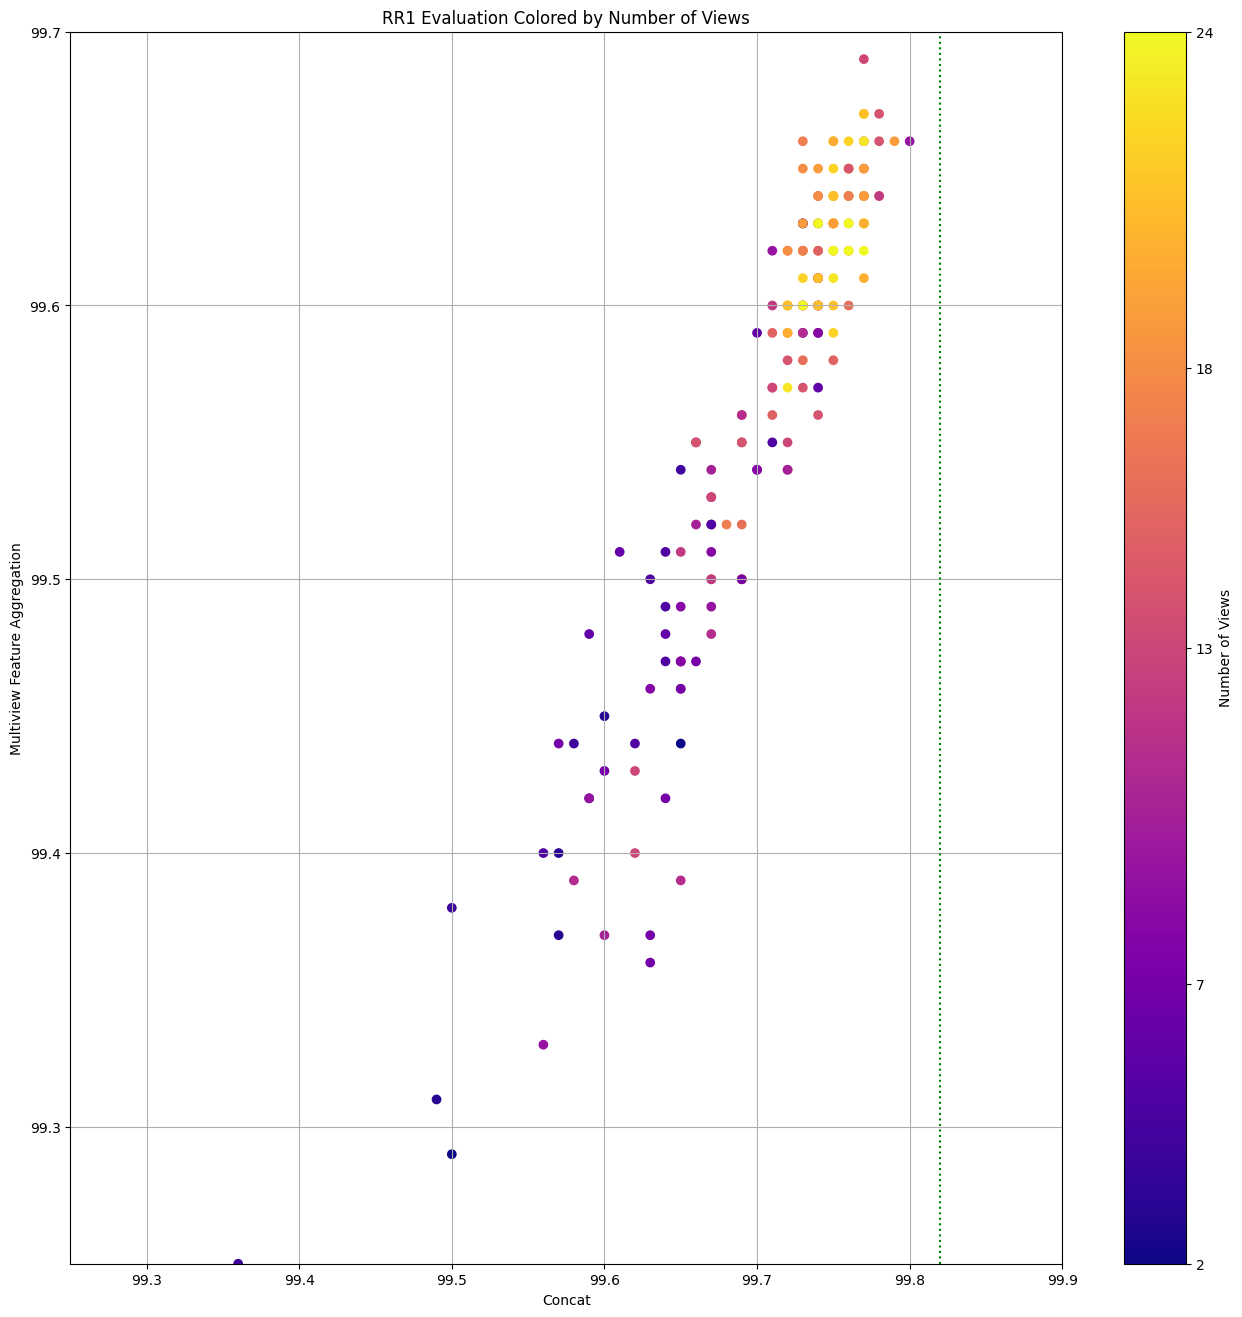

13 10
16 7
9 6
14 12
18 10
3 8
6 7
12 11
15 6
21 9
2 9
5 12
10 8
22 12
24 14
19 11
17 8
20 8
7 10
4 7
8 6
11 6
23 5


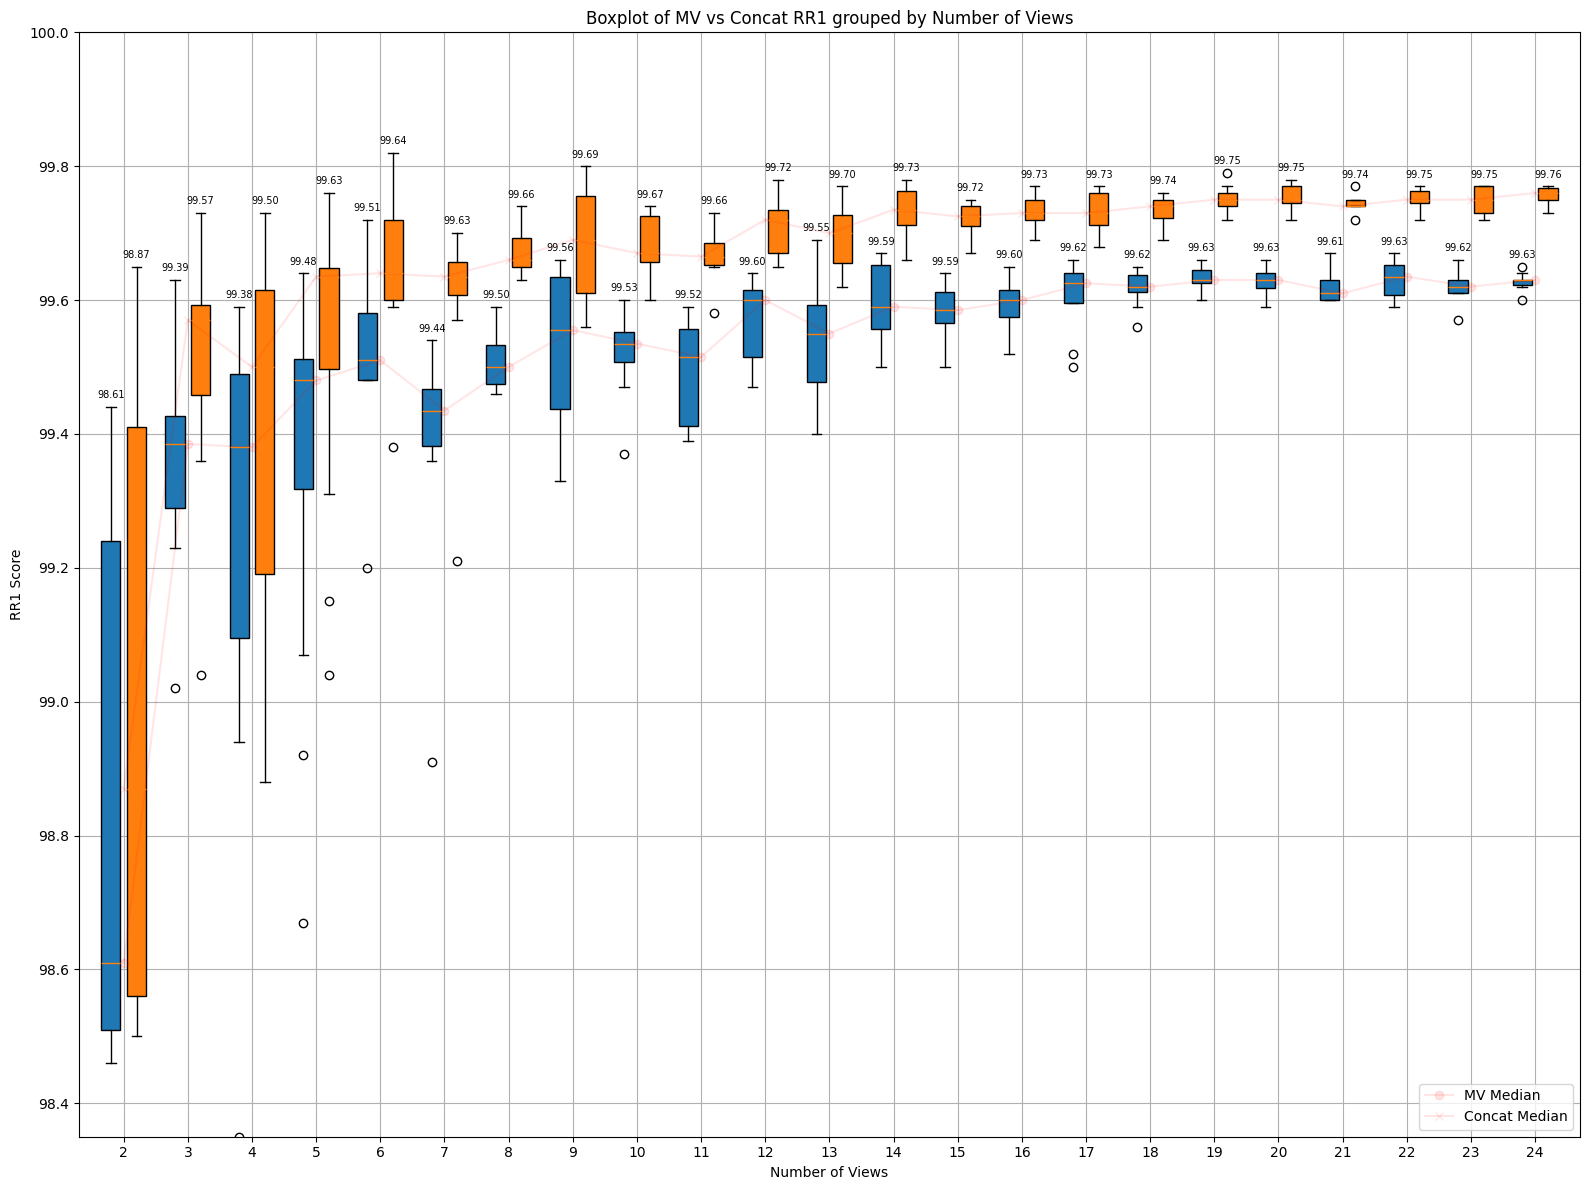

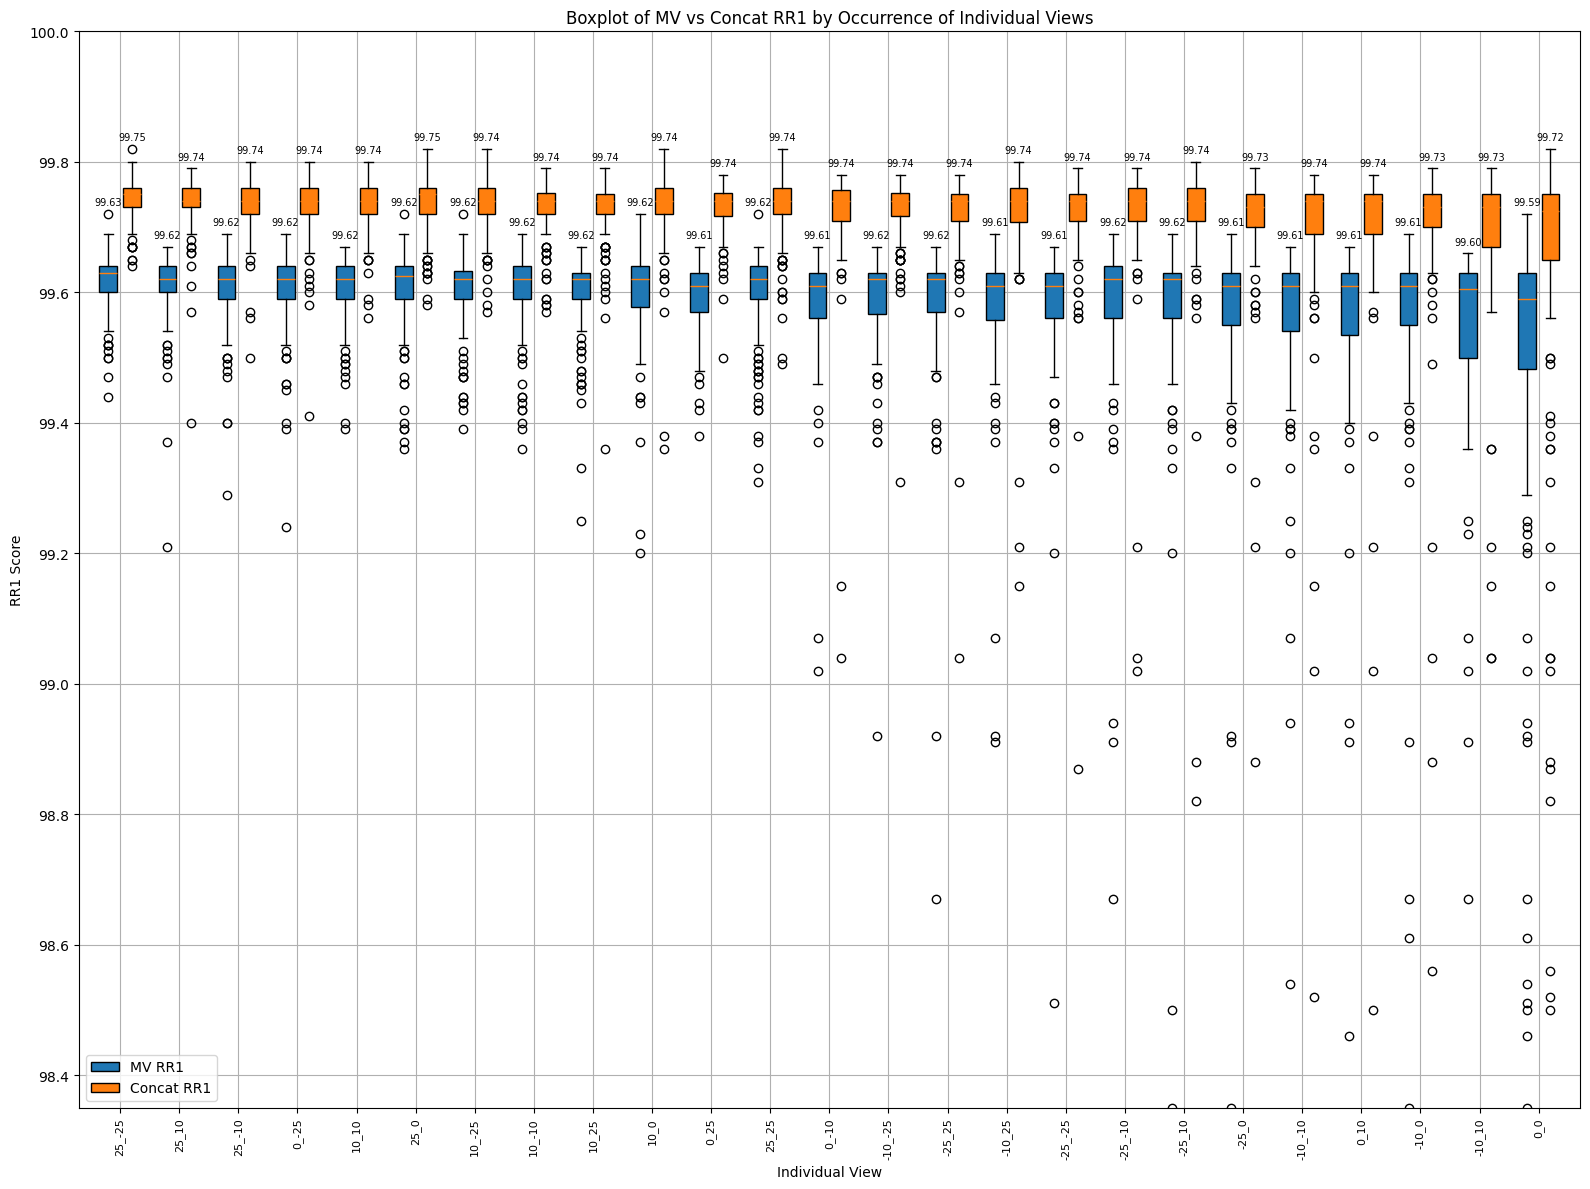

In [5]:
process_and_plot2('perspectives_ms1m_bff_nobias.txt', xlim=(99.25, 99.9), ylim=(99.25, 99.7))

Dataset len: 191


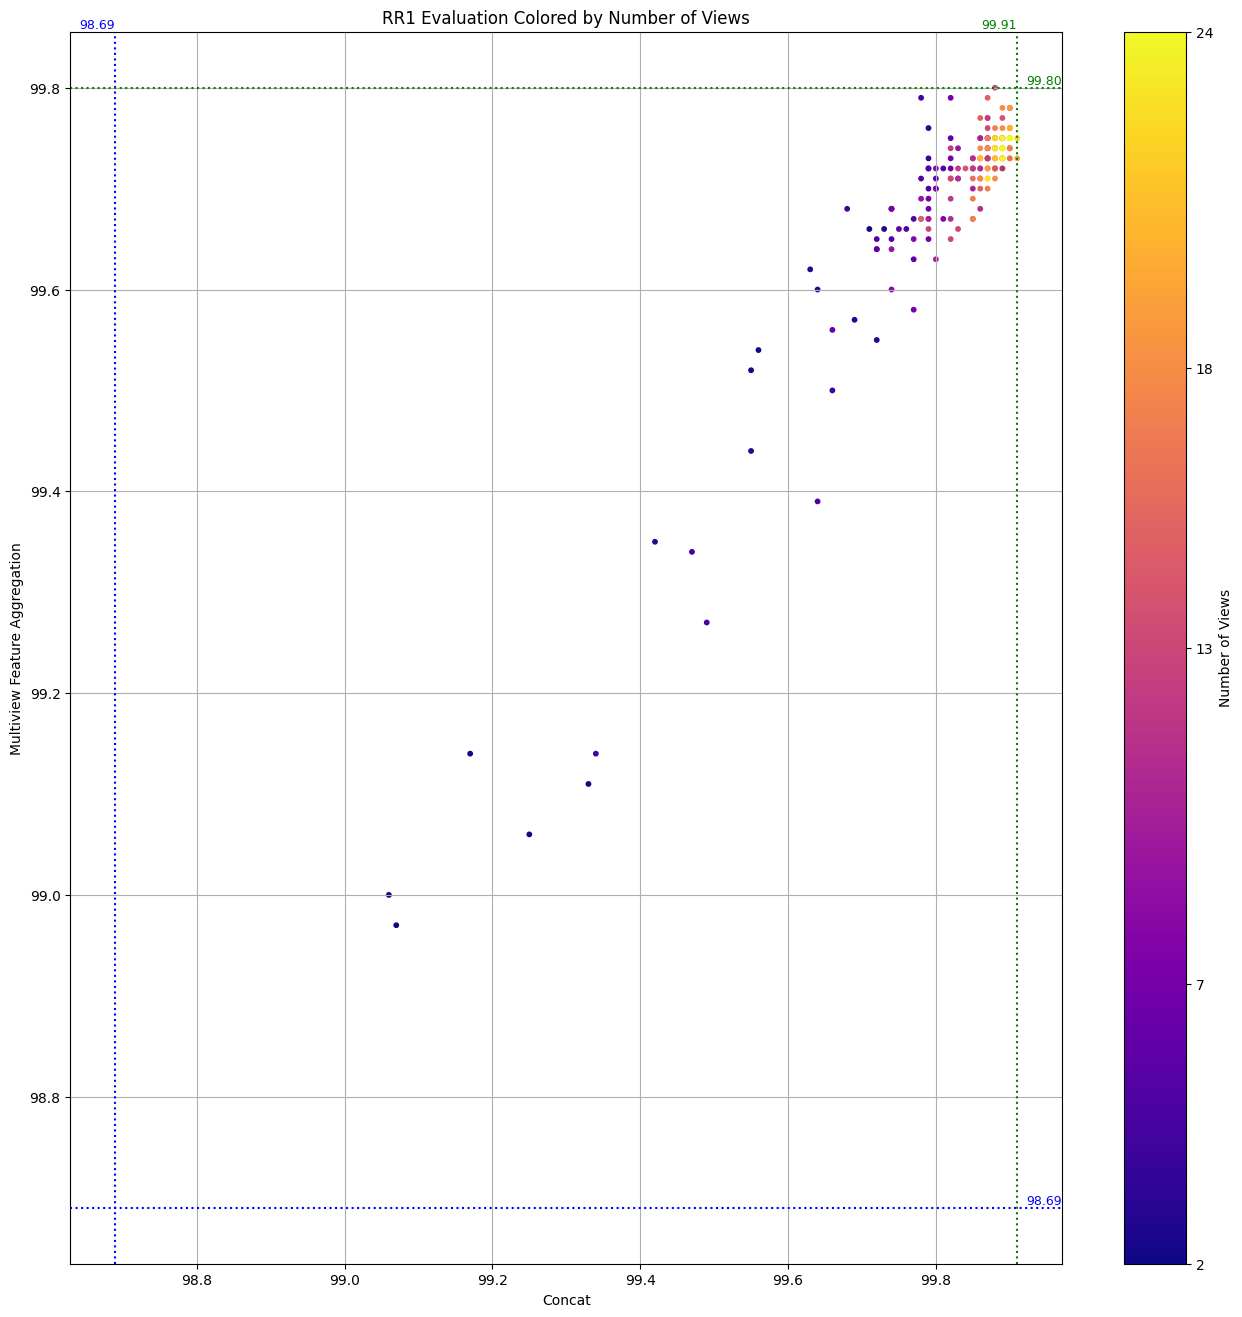

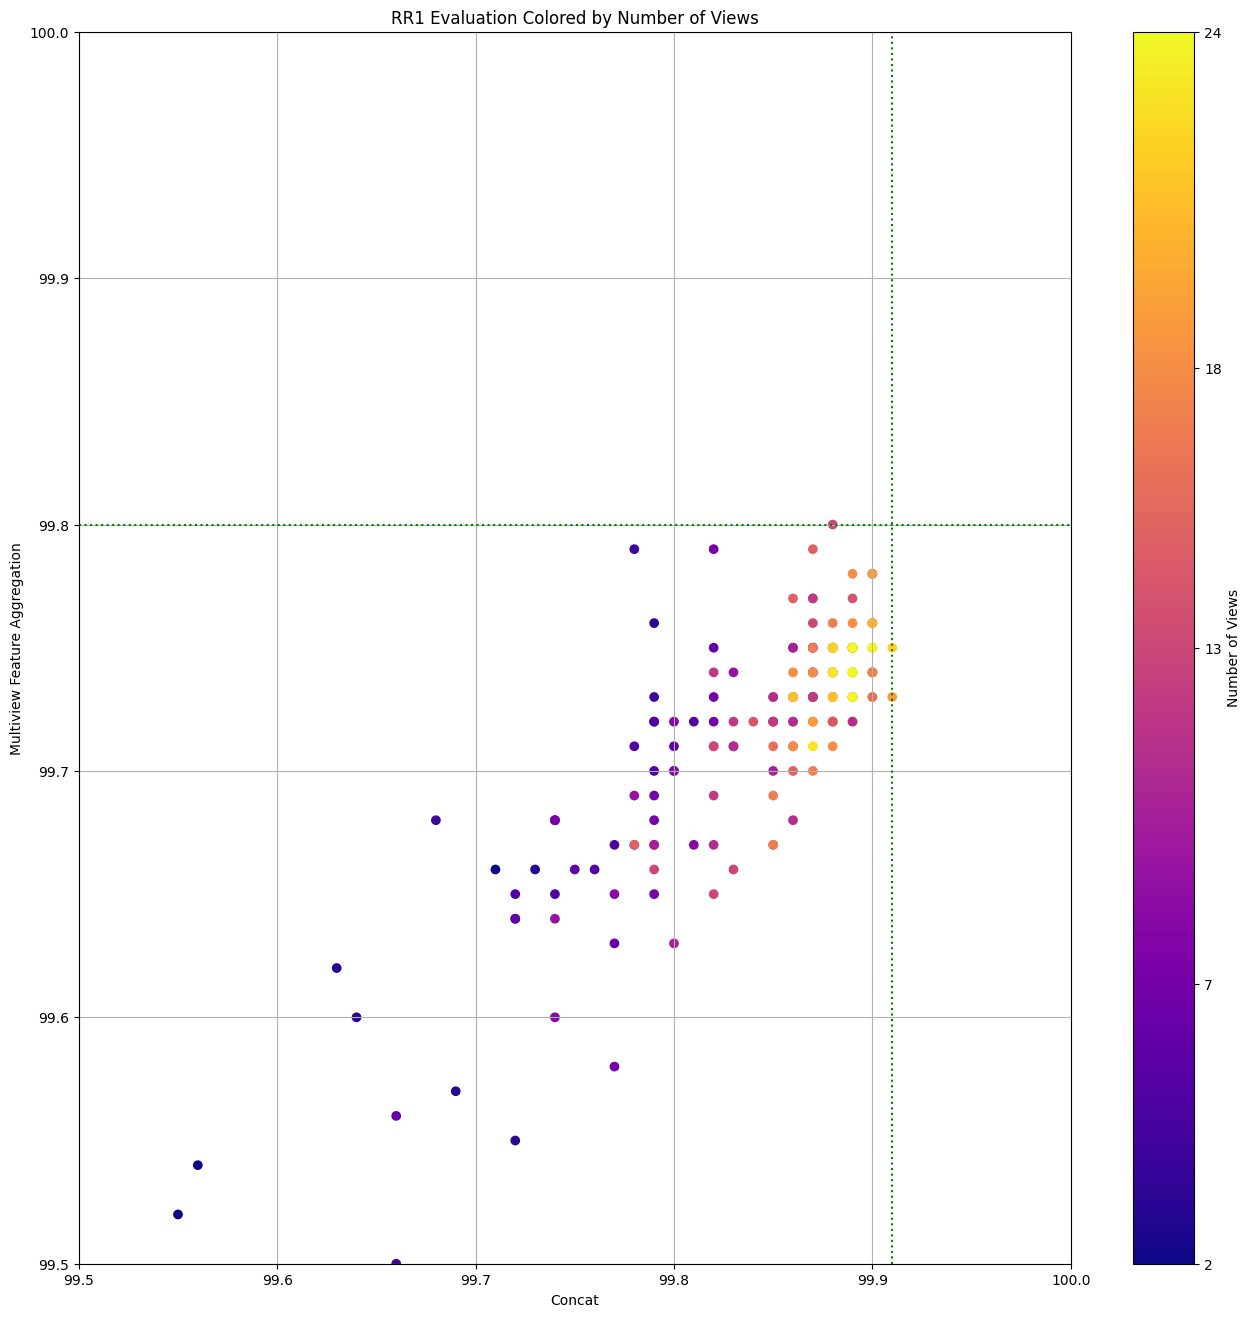

13 10
16 7
9 6
14 11
18 9
3 8
6 7
12 11
15 6
21 7
2 8
5 11
10 8
22 12
24 13
19 10
17 8
20 7
7 9
4 7
8 6
11 6
23 4


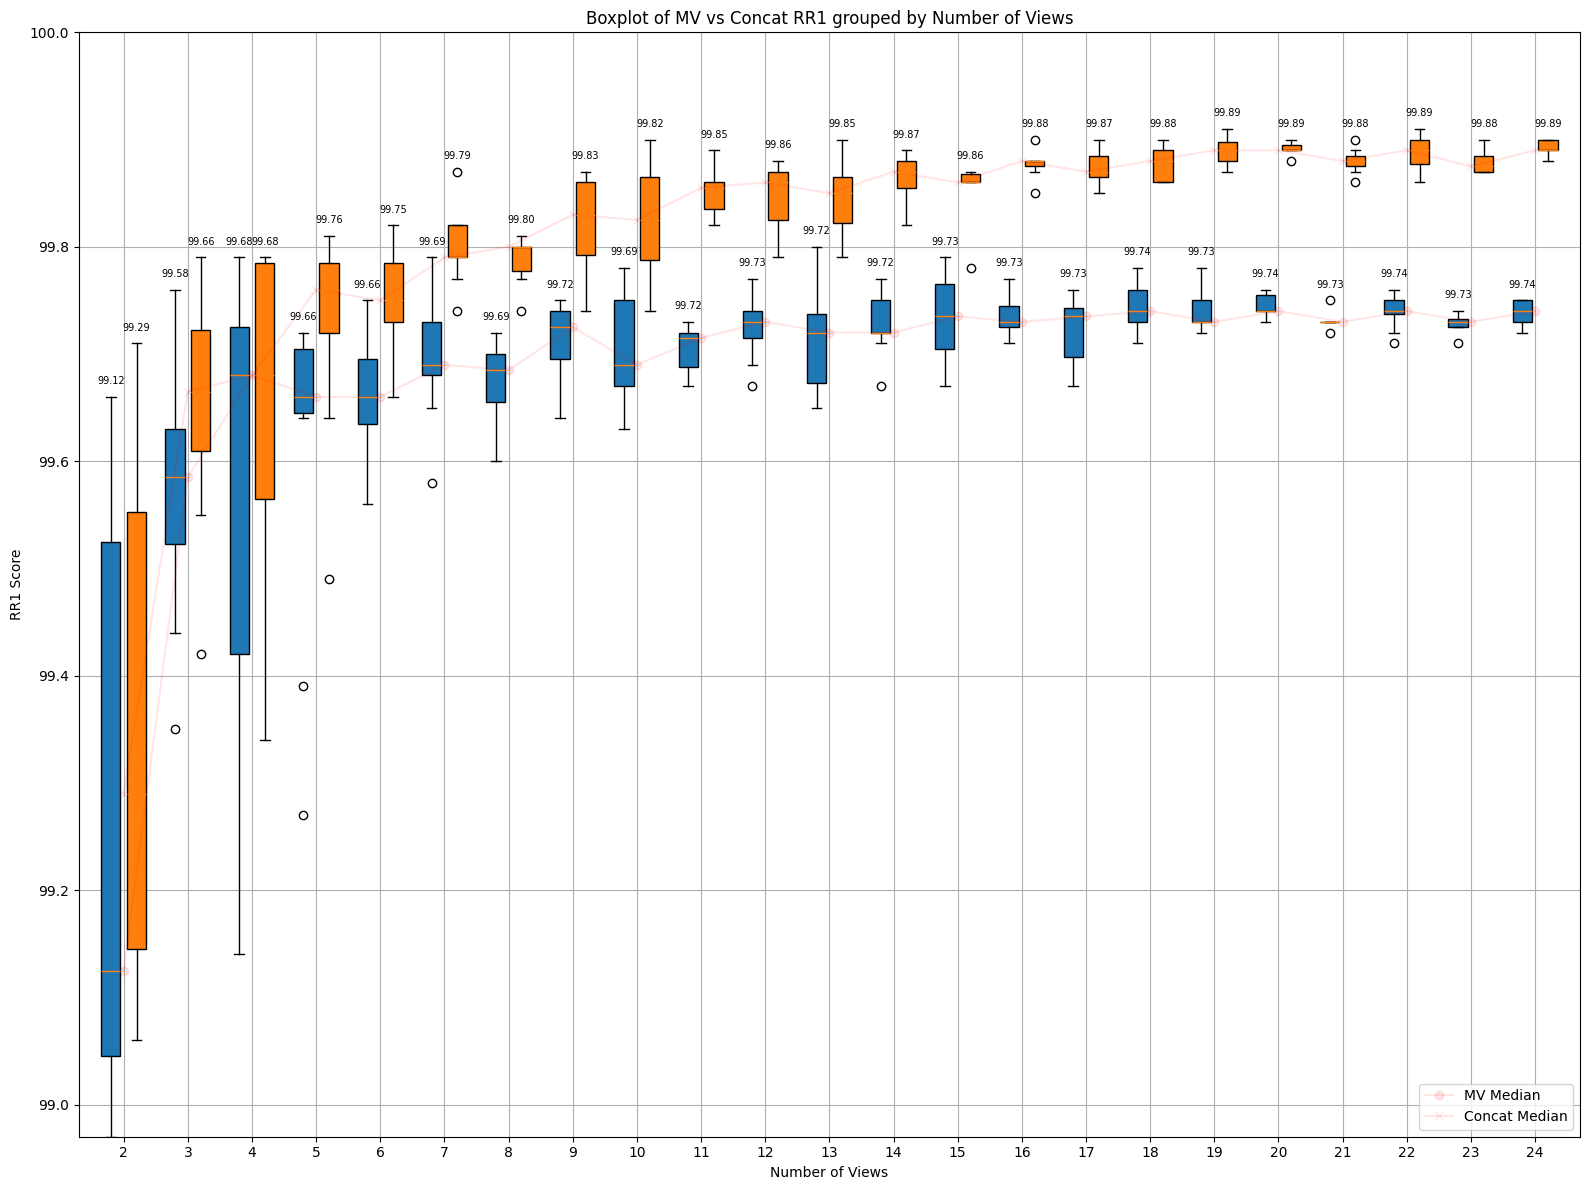

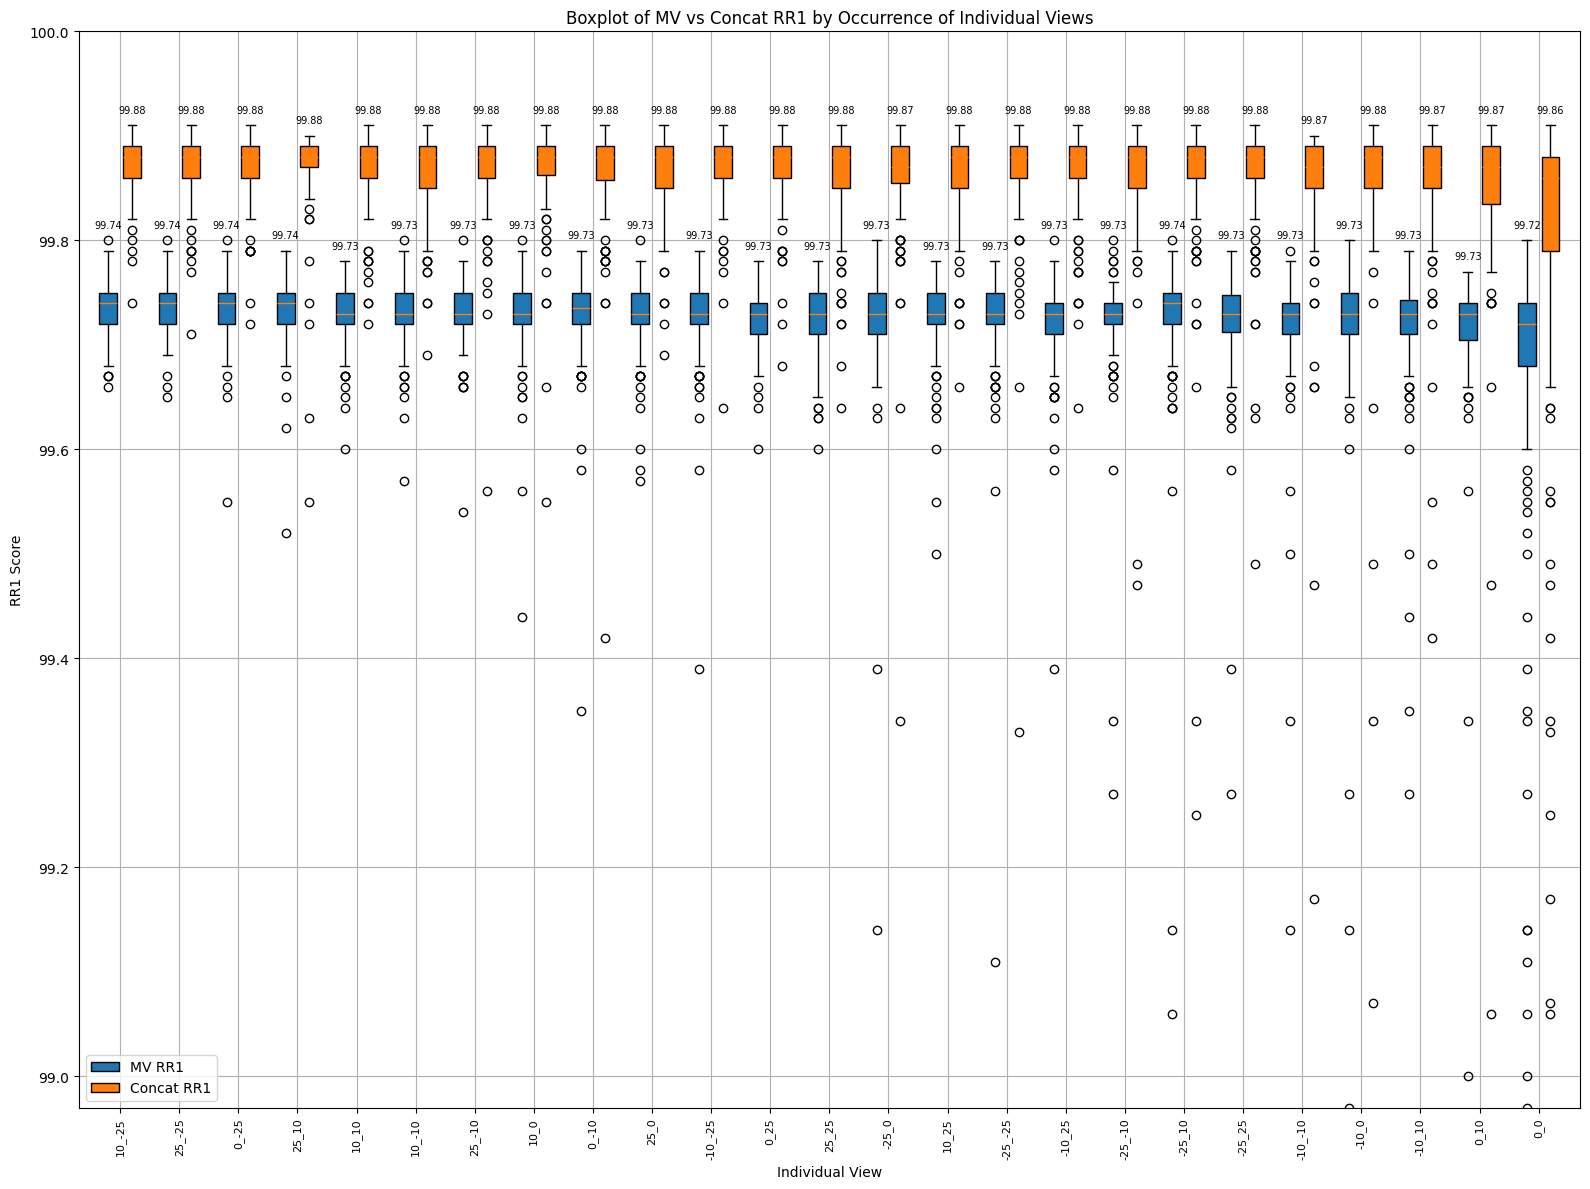

In [6]:
process_and_plot2('perspectives_asia_bff_nobias.txt', xlim=(99.5, 100), ylim=(99.5, 100))